<a href="https://colab.research.google.com/github/sujanpogithub/Machine-Learning/blob/main/face_mask_detection_with_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
#tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, Dense, Dropout,Flatten, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

In [ ]:
!pip install imutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


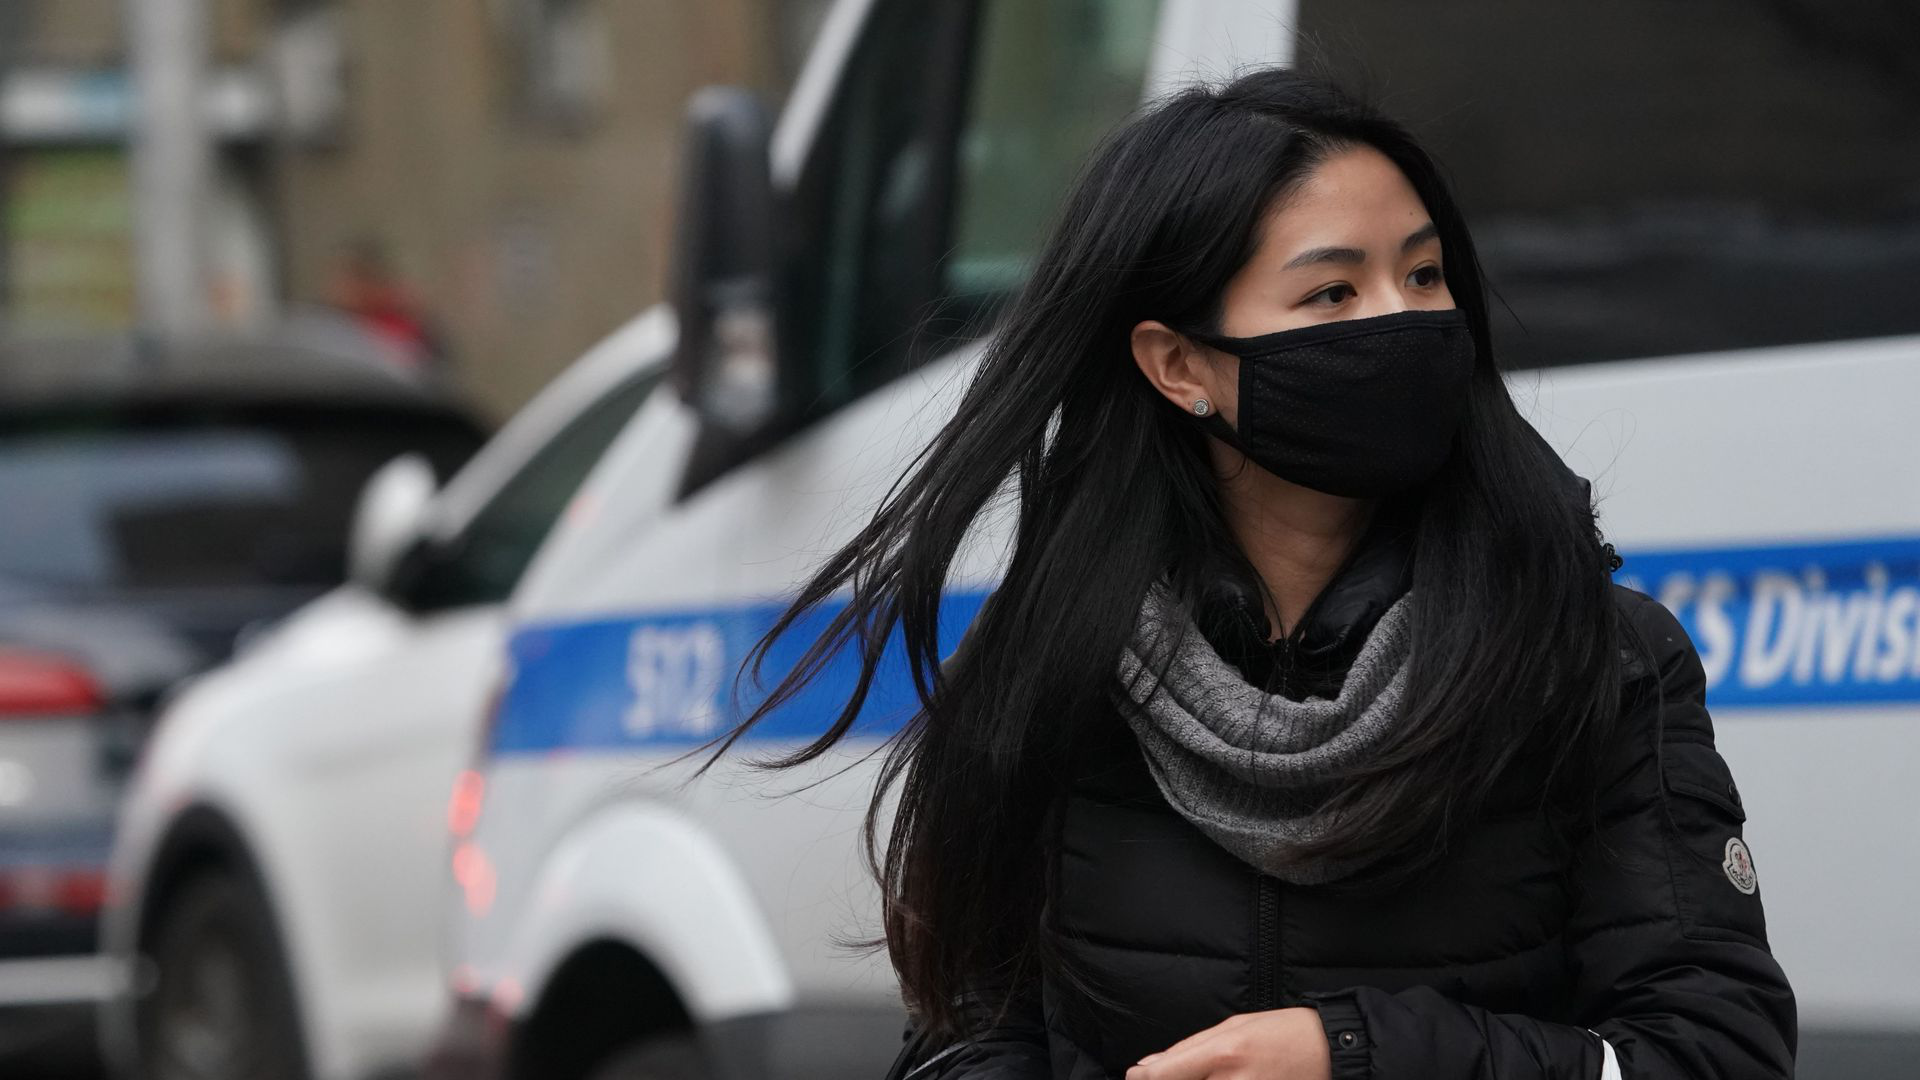

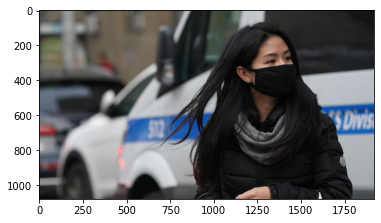

In [ ]:
from PIL import Image
from imutils import paths
data ='/content/gdrive/MyDrive/cnnnew/data'
Img_Paths = list(paths.list_images(data))

#Displaying sample image from dataset
sample1 = Image.open(Img_Paths[8])
plt.imshow(sample1)
sample1

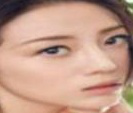

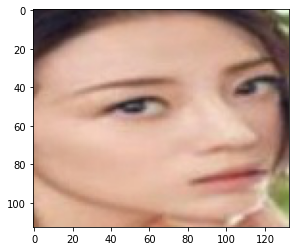

In [ ]:
sample2 = Image.open(Img_Paths[-5])
plt.imshow(sample2)
sample2

In [ ]:
with_mask_dir=r'/content/gdrive/MyDrive/cnnnew/data/with_mask'
without_mask_dir=r'/content/gdrive/MyDrive/cnnnew/data/without_mask'

In [ ]:
filepaths = []
labels= []
dict_list = [with_mask_dir, without_mask_dir]
for i, j in enumerate(dict_list):
    print(i)
    print(j)
    flist=os.listdir(j)
    #print(flist)
    for f in flist:
        fpath=os.path.join(j,f)
        filepaths.append(fpath)
        if i==0:
          labels.append('with_mask')
        else:
          labels.append('without_mask')

0
/content/gdrive/MyDrive/cnnnew/data/with_mask
1
/content/gdrive/MyDrive/cnnnew/data/without_mask


In [ ]:
Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")

In [ ]:
mask_data = pd.concat([Fseries,Lseries], axis=1)

In [ ]:
mask_df = pd.DataFrame(mask_data)

In [ ]:
print(mask_df.head())
print(mask_df["labels"].value_counts())

                                           filepaths     labels
0  /content/gdrive/MyDrive/cnnnew/data/with_mask/...  with_mask
1  /content/gdrive/MyDrive/cnnnew/data/with_mask/...  with_mask
2  /content/gdrive/MyDrive/cnnnew/data/with_mask/...  with_mask
3  /content/gdrive/MyDrive/cnnnew/data/with_mask/...  with_mask
4  /content/gdrive/MyDrive/cnnnew/data/with_mask/...  with_mask
without_mask    3828
with_mask       3725
Name: labels, dtype: int64


In [ ]:
mask_df.head()

,filepaths,labels
0,/content/gdrive/MyDrive/cnnnew/data/with_mask/...,with_mask
1,/content/gdrive/MyDrive/cnnnew/data/with_mask/...,with_mask
2,/content/gdrive/MyDrive/cnnnew/data/with_mask/...,with_mask
3,/content/gdrive/MyDrive/cnnnew/data/with_mask/...,with_mask
4,/content/gdrive/MyDrive/cnnnew/data/with_mask/...,with_mask


In [ ]:
#shape of datatset
mask_df.shape

(7553, 2)

In [ ]:
mask_df.columns

Index(['filepaths', 'labels'], dtype='object')

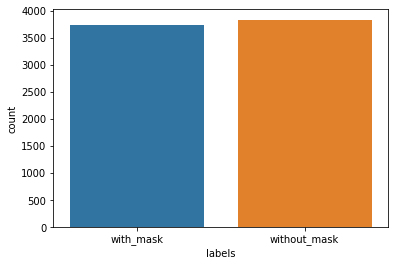

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# count plot on single categorical variable
sns.countplot(x ='labels', data = mask_df)

# Show the plot
plt.show()

In [ ]:
train_set, test_images = train_test_split(mask_df, test_size=0.3, random_state=42)
test_set, val_set = train_test_split(test_images, test_size=0.2, random_state=42)

In [ ]:
#Generate batches of tensor image data with real-time data augmentation.
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)

train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='grayscale',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=32,
                                      shuffle=False            #do not shuffle data
                                     )

test = image_gen.flow_from_dataframe(dataframe= test_set,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='grayscale',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )

val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'grayscale',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )

Found 5287 validated image filenames belonging to 2 classes.
Found 1812 validated image filenames belonging to 2 classes.
Found 454 validated image filenames belonging to 2 classes.


In [ ]:
classes=list(train.class_indices.keys())
print (classes)

['with_mask', 'without_mask']


In [ ]:
def show_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

In [ ]:
show_images(train)

In [ ]:
def plot_loss_and_accuracy(history):
    history_df = pd.DataFrame(history)
    history_df.loc[0:, ['loss', 'val_loss']].plot()
    history_df.loc[0:, ['accuracy', 'val_accuracy']].plot()

In [ ]:
import keras
from tensorflow.keras import layers

model_1 = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(244,244,1)),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

model_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model_1.optimizer.lr=0.001

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 244, 244, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 122, 122, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 60, 60, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 58, 58, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 29, 29, 32)       0

In [ ]:
history_CNN = model_1.fit(train, validation_data= val, epochs=15,verbose=1)

Epoch 1/15
166/166 [==============================] - 845s 5s/step - loss: 0.5543 - accuracy: 0.7172 - val_loss: 0.4243 - val_accuracy: 0.8128
Epoch 2/15
166/166 [==============================] - 25s 150ms/step - loss: 0.3386 - accuracy: 0.8538 - val_loss: 0.2785 - val_accuracy: 0.8744
Epoch 3/15
166/166 [==============================] - 26s 156ms/step - loss: 0.2384 - accuracy: 0.9052 - val_loss: 0.2611 - val_accuracy: 0.8700
Epoch 4/15
166/166 [==============================] - 24s 146ms/step - loss: 0.1872 - accuracy: 0.9264 - val_loss: 0.2596 - val_accuracy: 0.8943
Epoch 5/15
166/166 [==============================] - 26s 157ms/step - loss: 0.1346 - accuracy: 0.9451 - val_loss: 0.2680 - val_accuracy: 0.8789
Epoch 6/15
166/166 [==============================] - 24s 144ms/step - loss: 0.1082 - accuracy: 0.9614 - val_loss: 0.2384 - val_accuracy: 0.8943
Epoch 7/15
166/166 [==============================] - 25s 148ms/step - loss: 0.0781 - accuracy: 0.9718 - val_loss: 0.2637 - val_accu

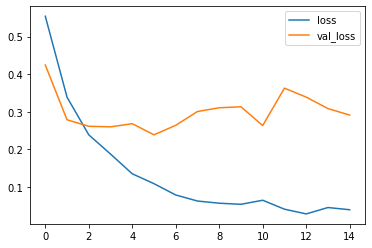

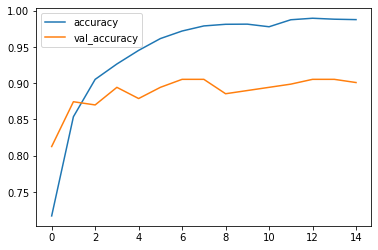

In [ ]:
#resuts from model 1
plot_loss_and_accuracy(history_CNN.history)

In [ ]:
pred = model_1.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

y_test = test_set.labels # set y_test to the expected output
print(classification_report(y_test, pred2))

57/57 [==============================] - 211s 4s/step
              precision    recall  f1-score   support

   with_mask       0.93      0.93      0.93       889
without_mask       0.93      0.93      0.93       923

    accuracy                           0.93      1812
   macro avg       0.93      0.93      0.93      1812
weighted avg       0.93      0.93      0.93      1812



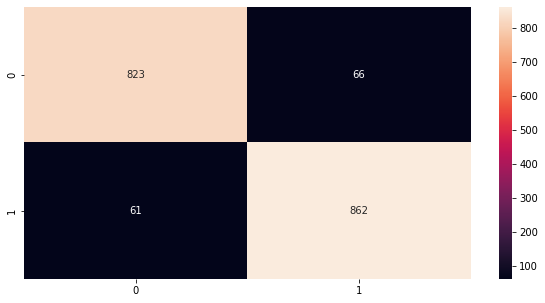

In [ ]:
# model 1
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize = (10,5))
cm = confusion_matrix(y_test, pred2)
sns.heatmap(cm, annot=True, fmt = 'g')

In [ ]:
model_1.save("face_mask.h5")